### OCI Data Science - Useful Tips
<details>
<summary><font size="2">Check for Public Internet Access</font></summary>

```python
import requests
response = requests.get("https://oracle.com")
assert response.status_code==200, "Internet connection failed"
```
</details>
<details>
<summary><font size="2">Helpful Documentation </font></summary>
<ul><li><a href="https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm">Data Science Service Documentation</a></li>
<li><a href="https://docs.cloud.oracle.com/iaas/tools/ads-sdk/latest/index.html">ADS documentation</a></li>
</ul>
</details>
<details>
<summary><font size="2">Typical Cell Imports and Settings for ADS</font></summary>

```python
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.ERROR)

import ads
from ads.dataset.factory import DatasetFactory
from ads.automl.provider import OracleAutoMLProvider
from ads.automl.driver import AutoML
from ads.evaluations.evaluator import ADSEvaluator
from ads.common.data import ADSData
from ads.explanations.explainer import ADSExplainer
from ads.explanations.mlx_global_explainer import MLXGlobalExplainer
from ads.explanations.mlx_local_explainer import MLXLocalExplainer
from ads.catalog.model import ModelCatalog
from ads.common.model_artifact import ModelArtifact
```
</details>
<details>
<summary><font size="2">Useful Environment Variables</font></summary>

```python
import os
print(os.environ["NB_SESSION_COMPARTMENT_OCID"])
print(os.environ["PROJECT_OCID"])
print(os.environ["USER_OCID"])
print(os.environ["TENANCY_OCID"])
print(os.environ["NB_REGION"])
```
</details>

In [1]:
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Settings for plots
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 15
sns.set(color_codes=True)
sns.set(font_scale=1.5)
sns.set_palette("bright")
sns.set_style("whitegrid")

import automlx
from automlx import init

In [2]:
# Fetch example data set
dataset = fetch_openml(name='adult', as_frame=True)
df, y = dataset.data, dataset.target

In [3]:
# Output header data for quick inspection
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
0,2,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States
1,3,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States
2,2,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States
3,3,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States
4,1,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba


In [4]:
# Output default data types detected by the fetch (notice all are not correct, e.g., see "age" incorrectly listed as "category")
pd.DataFrame({'Data type': df.dtypes}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
Data type,category,category,float64,category,float64,category,category,category,category,category,category,category,category,category


In [5]:
# Output % missing values per column
pd.DataFrame({'% missing vlaues': df.isnull().sum() * 100 / len(df)}).T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country
% missing vlaues,0.0,5.730724,0.0,0.0,0.0,0.0,5.751198,0.0,0.0,0.0,0.0,0.0,0.0,1.754637


[Text(0, 0, '37155'), Text(0, 0, '11687')]

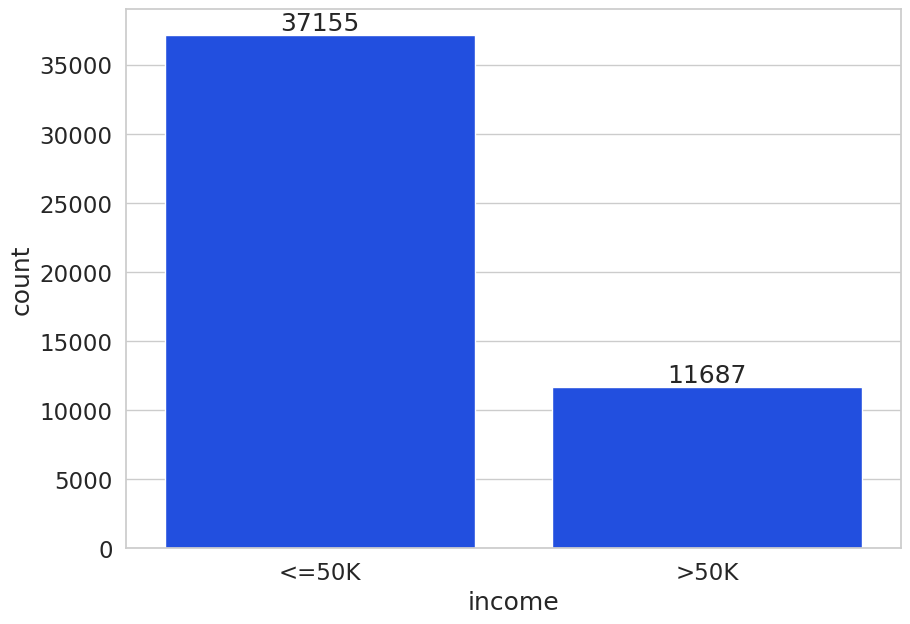

In [6]:
# visualize the distribution of the target variable (income)
y_df = pd.DataFrame(y)
y_df.columns = ['income']

ax = sns.countplot(x="income", data=y_df)
ax.bar_label(ax.containers[0])

In [7]:
# Correct the incorrect column data types
numeric_columns = ['age', 'capitalgain', 'capitalloss', 'hoursperweek']
for col in df.columns:
    if col in numeric_columns:
        df[col] = df[col].astype(int)
        
        
# Split the data set into training and test data
X_train, X_test, y_train, y_test = train_test_split(df,
                                                    y.map({'>50K': 1, '<=50K': 0}).astype(int),
                                                    train_size=0.7,
                                                    random_state=0)

# Output the shap of the training and test data sets
X_train.shape, X_test.shape

((34189, 14), (14653, 14))

In [8]:
# Initialize the AutoML Engine, setting it to use Python's parallelism library
init(engine='local')

In [9]:
# Create and fit a model using the AutoML Piepline (Preprocessing > Algorithm Selection > Adaptive Sampling > Feature Selection > Hyperparameter Tuning)
est1 = automlx.Pipeline(task='classification')
est1.fit(X_train, y_train)

[2025-10-18 17:32:58,921] [automlx.interface] Dataset shape: (34189,14)
[2025-10-18 17:32:59,030] [automlx.data_transform] Running preprocessing. Number of features: 15
[2025-10-18 17:33:00,107] [automlx.data_transform] Preprocessing completed. Took 1.077 secs
[2025-10-18 17:33:00,116] [automlx.process] Running Model Generation
[2025-10-18 17:33:00,167] [automlx.process] KNeighborsClassifier is disabled. The KNeighborsClassifier model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-18 17:33:00,173] [automlx.process] SVC is disabled. The SVC model is only recommended for datasets with less than 10000 samples and 1000 features.
[2025-10-18 17:33:00,179] [automlx.process] Model Generation completed.
[2025-10-18 17:33:00,244] [automlx.model_selection] Running Model Selection
[LightGBM] [Info] Number of positive: 2000, number of negative: 2000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002367 seconds.
You

In [10]:
# Evaluate the effectiveness of the module
y_proba = est1.predict_proba(X_test)
score_default = roc_auc_score(y_test, y_proba[:, 1])

print(f'Score on test data: {score_default}')

Score on test data: 0.9140858492615117


In [11]:
# Summarize the AutoML activity
est1.print_summary()

""
"(34189, 14)"
None
"KFoldSplit(Shuffle=True, Seed=7, folds=5, stratify by=target)"
neg_log_loss
XGBClassifier
"{'learning_rate': 0.10242113515453982, 'min_child_weight': 2, 'max_depth': 4, 'reg_alpha': 0.0007113117640155693, 'booster': 'gbtree', 'reg_lambda': 1.001, 'n_estimators': 141, 'use_label_encoder': False}"
25.1.1
"3.11.11 | packaged by conda-forge | (main, Mar 3 2025, 20:43:55) [GCC 13.3.0]"


Step,# Samples,# Features,Algorithm,Hyperparameters,Score (neg_log_loss),All Metrics,Runtime (Seconds),Memory Usage (GB),Finished
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3813,{'neg_log_loss': -0.38129734602336923},2.5187,0.2827,Sat Oct 18 17:35:03 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,CatBoostClassifier,"{'iterations': 235, 'learning_rate': 0.787168, 'leaf_estimation_method': 'Newton', 'colsample_bylevel': 0.096865, 'depth': 3, 'l2_leaf_reg': 2.567326, 'feature_border_type': 'UniformAndQuantiles', 'model_size_reg': 3.85132, 'leaf_estimation_iterations': 1, 'boosting_type': 'Plain', 'bootstrap_type': 'MVS', 'auto_class_weights': 'SqrtBalanced', 'allow_writing_files': False, 'allow_const_label': True}",-0.3881,{'neg_log_loss': -0.38808832474759775},2.7114,0.3043,Sat Oct 18 17:33:09 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LGBMClassifier,"{'num_leaves': 31, 'boosting_type': 'gbdt', 'learning_rate': 0.1, 'min_child_weight': 0.001, 'max_depth': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'n_estimators': 100, 'class_weight': 'balanced'}",-0.3898,{'neg_log_loss': -0.3898051926295403},4.9038,0.2659,Sat Oct 18 17:33:21 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,LogisticRegressionClassifier,"{'C': 1.0, 'solver': 'liblinear', 'class_weight': 'balanced'}",-0.3908,{'neg_log_loss': -0.3907935186356912},0.4303,0.2519,Sat Oct 18 17:35:04 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,RandomForestClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced'}",-0.4093,{'neg_log_loss': -0.40930045927988673},6.3510,0.2619,Sat Oct 18 17:33:27 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,ExtraTreesClassifier,"{'n_estimators': 100, 'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 0.777777778, 'class_weight': 'balanced', 'criterion': 'gini'}",-0.4196,{'neg_log_loss': -0.4196315514455088},5.0663,0.2643,Sat Oct 18 17:33:15 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,TorchMLPClassifier,"{'optimizer_class': 'Adam', 'shuffle_dataset_each_epoch': True, 'optimizer_params': {}, 'criterion_class': None, 'criterion_params': {}, 'scheduler_class': None, 'scheduler_params': {}, 'batch_size': 128, 'lr': 0.001, 'epochs': 18, 'input_transform': 'auto', 'tensorboard_dir': None, 'use_tqdm': None, 'prediction_batch_size': 128, 'prediction_input_transform': 'auto', 'shuffling_buffer_size': None, 'depth': 4, 'num_logits': 1000, 'div_factor': 2, 'activation': 'ReLU', 'dropout': 0.1}",-0.6269,{'neg_log_loss': -0.6268772114005255},106.0894,0.6658,Sat Oct 18 17:35:00 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,GaussianNB,{},-1.0622,{'neg_log_loss': -1.0622002049203993},0.3500,0.2500,Sat Oct 18 17:33:15 2025
Model Selection,"{1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000}",15,DecisionTreeClassifier,"{'min_samples_split': 0.00125, 'min_samples_leaf': 0.000625, 'max_features': 1.0, 'class_weight': None}",-4.6323,{'neg_log_loss': -4.632288461805368},0.4505,0.2503,Sat Oct 18 17:33:09 2025
Adaptive Sampling,"{1: 6730, 2: 6730, 3: 6730, 4: 6730, 5: 6730}",15,AdaptiveSamplingStage_XGBClassifier,"{'learning_rate': 0.1, 'min_child_weight': 1, 'max_depth': 3, 'reg_alpha': 0, 'booster': 'gbtree', 'reg_lambda': 1, 'n_estimators': 100, 'use_label_encoder': False}",-0.3782,{'neg_log_loss': -0.37817011702109865},7.3312,0.2990,Sat Oct 18 17:35:15 2025


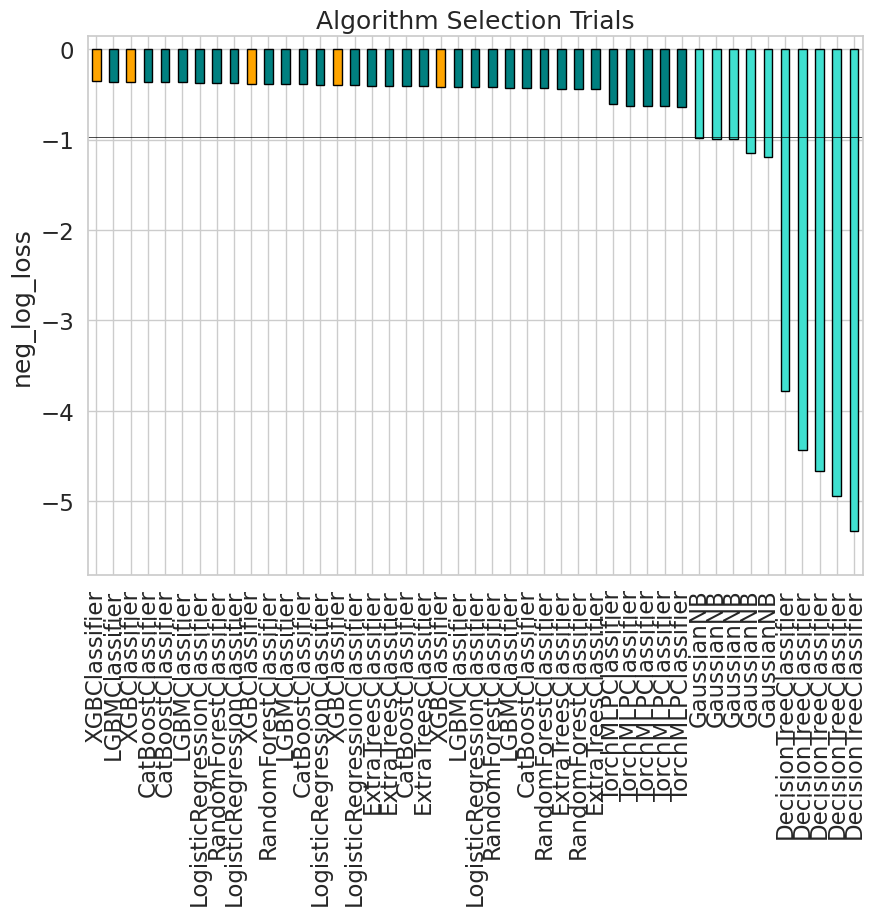

In [56]:
# Output the results of the completed Model Selection values
trials_raw = est1.completed_trials_detailed_
trials = trials_raw[trials_raw['Step'] == 'Model Selection']

colors = []
scores = trials['Score (neg_log_loss)'].tolist()
models = trials['Algorithm'].tolist()

y_margin = 0.10 * (max(scores) - min(scores))
s = pd.Series(scores, index=models).sort_values(ascending=False)

for index, value in s.items():
    if index == est1.selected_model_:
        colors.append('orange')
    elif value >= s.mean():
        colors.append('teal')
    else:
        colors.append('turquoise')
        
fig, ax = plt.subplots(1)
ax.set_title("Algorithm Selection Trials")
ax.set_ylim(min(scores) - y_margin, max(scores) + y_margin)
ax.set_ylabel('neg_log_loss')
s.plot.bar(ax=ax, color=colors, edgecolor='black')
ax.axhline(y=s.mean(), color='black', linewidth=0.5)
plt.show()